In [134]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import math
import random
from collections import defaultdict
from datetime import datetime, timedelta
from scipy.stats import variation
from file_helpers import create_presence_locations_cam_cache_filename, create_presence_cache_filename, create_presence_locations_cache_filename
from bee_helpers import calc_trip_starts

#from joblib import Parallel, delayed
import multiprocessing
from skimage.filters import threshold_minimum, threshold_mean
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.dummy import DummyClassifier

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

from bb_utils.ids import BeesbookID
from bb_utils import meta, ids
#from data_utils.visualization import bivariate_kdeplot
import psycopg2

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
connect_str = """dbname='beesbook' 
                 user='postgres' 
                 host='tonic.imp.fu-berlin.de' 
                 password='' 
                 application_name='ben_bee_features'"""

In [3]:
from bb_utils import meta
from datetime import timedelta, datetime
from tqdm import tqdm_notebook
from tqdm import tqdm

In [4]:
num_weeks = 8
num_days = 7 * num_weeks
days_after = 7 * 2

group_idx = 25

reference_date = meta.BeeMetaInfo().get_foragergroup(group_idx).date
start_date = reference_date + timedelta(days_after) - timedelta(num_days)
end_date = reference_date + timedelta(days_after)

cache_location_prefix = "../caches/"
detections_cache_path = cache_location_prefix + "Detections/"
num_days_to_process = 2

assert (end_date < datetime(2016, 9, 19))
assert (start_date > datetime(2016, 7, 19))

start_date, reference_date + timedelta(days_after)

(Timestamp('2016-07-22 00:00:00'), Timestamp('2016-09-16 00:00:00'))

In [5]:
from tqdm import tnrange

In [6]:
def feature_compute_job(day):
    class TrackFeatures:
        def __init__(self, ts_begin, ts_end, confidence=.95, min_track_len=3):
            self.ts_begin = ts_begin
            self.ts_end = ts_end
            self.confidence = confidence
            self.min_track_len = min_track_len
            self.meta = meta.BeeMetaInfo()

            self.exit_positions = {
                0: np.array([6000 - 50, 280]),
                1: np.array([3950, 280]),
                2: np.array([250, 300]),
                3: np.array([6000 - 250, 4000 - 300])
            }

            self.prefix_query = """
            SET geqo_effort to 10;
            SET max_parallel_workers_per_gather TO 8;
            SET temp_buffers to "32GB";
            SET work_mem to "1GB";
            SET temp_tablespaces to "ssdspace";
            """

        @staticmethod
        def process_group(group, min_track_len, exit_positions):
            if len(group) < min_track_len:
                return None

            exit_pos = exit_positions[group.cam_id.unique()[0]]
            group = group.sort_values('timestamp', ascending=True)

            bee_id = group.bee_id.unique()[0]
            dt = group['timestamp'].diff()
            valid = dt.apply(lambda t: t.total_seconds()).values[1:] < (.3 * 2)

            dv = group[['x_pos', 'y_pos']].diff()[1:].apply(
                np.linalg.norm, axis=1).values
            valid = np.logical_and(valid, dv < np.expm1(6))
            dv = dv[valid]
            hd = np.linalg.norm(
                group[['x_pos', 'y_pos']].values - exit_pos[None, :], axis=1)

            return bee_id, dv, hd

        def get_data(self, conn):
            data_query = """
                SELECT q.* 
                FROM (
                    SELECT * from bb_detections_2016_stitched
                    WHERE timestamp >= %s
                        AND timestamp < %s
                        AND bee_id_confidence > %s
                        AND MOD(track_id, 4) = 0
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));
            """
            feature_query = """
                SELECT *, oid as combined_id
                INTO TEMPORARY TABLE frame_ids
                FROM matching_frames_2016
                WHERE timestamp_a >= %s
                    AND timestamp_a < %s
                ORDER BY RANDOM() 
                LIMIT 2000;

                SELECT q.*
                INTO TEMPORARY TABLE detections
                FROM (
                    SELECT frame_id, bee_id, x_pos_hive, y_pos_hive, timestamp, cam_id
                    FROM bb_detections_2016_stitched
                    WHERE frame_id in (SELECT frame_id_a FROM frame_ids UNION
                        SELECT frame_id_b FROM frame_ids)
                        AND bee_id_confidence > .95
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));

                SELECT * 
                INTO TEMPORARY TABLE detections_with_combined_id
                FROM (
                    SELECT *
                    FROM detections A
                    INNER JOIN frame_ids B ON A.frame_id = B.frame_id_a
                    UNION 
                    SELECT *
                    FROM detections A
                    INNER JOIN frame_ids B ON A.frame_id = B.frame_id_b
                ) q;

                SELECT A.bee_id as bee_id_a,
                    B.bee_id as bee_id_b,
                    (|/((A.x_pos_hive - B.x_pos_hive) ^ 2 + (A.x_pos_hive - B.x_pos_hive) ^ 2)) as distance,
                    A.combined_id as frame_id
                INTO TEMPORARY TABLE distances
                FROM detections_with_combined_id A
                INNER JOIN detections_with_combined_id B
                ON A.combined_id = B.combined_id
                WHERE A.cam_id <> B.cam_id;

                SELECT bee_id_a as bee_id, avg(distance) as avg_distance
                INTO TEMPORARY TABLE avg_distance
                FROM distances
                GROUP BY bee_id_a;

                SELECT bee_id, avg(count) as avg_neighbors_15
                INTO TEMPORARY TABLE avg_neighbors_15
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a)
                    FROM distances
                    WHERE distance < 15
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id, avg(count) as avg_neighbors_30
                INTO TEMPORARY TABLE avg_neighbors_30
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a) 
                    FROM distances
                    WHERE distance < 30
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id, avg(count) as avg_neighbors_50
                INTO TEMPORARY TABLE avg_neighbors_50
                FROM (
                    SELECT bee_id_a as bee_id, frame_id, count(bee_id_a) 
                    FROM distances
                    WHERE distance < 50
                    GROUP BY frame_id, bee_id
                ) q2 GROUP BY bee_id;

                SELECT bee_id_a as bee_id, avg(distance) as avg_distance_queen
                INTO TEMPORARY TABLE avg_distance_queen
                FROM (
                    SELECT * FROM distances
                    WHERE bee_id_b = 1901
                ) query
                GROUP BY bee_id_a;
                
                SELECT q.* 
                INTO TEMPORARY TABLE num_dances_tmp
                FROM (
                    SELECT bee_id, MIN(wdd_dances.timestamp_begin) as timestamp, COUNT(*) as num_dances
                    FROM wdd_dances_to_bb_detections
                    NATURAL JOIN wdd_dances
                    WHERE wdd_dances.valid = True
                        AND timestamp_begin >= %s
                        AND timestamp_end < %s
                    GROUP BY bee_id
                ) q
                INNER JOIN alive_bees_2016 
                ON (alive_bees_2016.bee_id = q.bee_id) AND
                   (EXTRACT(doy FROM alive_bees_2016.timestamp) = EXTRACT(doy FROM q.timestamp));

                SELECT *
                INTO TEMPORARY TABLE results_tmp
                FROM avg_distance
                NATURAL JOIN avg_neighbors_15
                NATURAL JOIN avg_neighbors_30
                NATURAL JOIN avg_neighbors_50
                NATURAL JOIN avg_distance_queen;
                
                SELECT results_tmp.*, coalesce(num_dances_tmp.num_dances, 0) as num_dances
                FROM results_tmp
                LEFT JOIN num_dances_tmp
                ON results_tmp.bee_id = num_dances_tmp.bee_id
                """

            with conn:
                with conn.cursor() as cur:
                    cur.execute(self.prefix_query)
                    self.data = pd.read_sql_query(
                        data_query,
                        conn,
                        params=(self.ts_begin, self.ts_end, self.confidence),
                        coerce_float=False)
                    self.sql_features = pd.read_sql_query(
                        feature_query,
                        conn,
                        coerce_float=False,
                        params=(self.ts_begin, self.ts_end, self.ts_begin, self.ts_end))
                    self.sql_features['Age'] = [
                        self.meta.get_age(
                            BeesbookID.from_ferwar(k),
                            datetime.combine(self.ts_begin.date(),
                                             datetime.min.time())).days
                        for k in self.sql_features.bee_id.values
                    ]

        def get_features(self):
            assert self.data is not None

            df_grouped = self.data.groupby('track_id')

            dvs = defaultdict(list)
            hds = defaultdict(list)

            results = [TrackFeatures.process_group(group, self.min_track_len, self.exit_positions) for name, group in df_grouped]
            for res in results:
                if res is not None:
                    bee_id, dv, hd = res

                    dvs[bee_id].append(dv)
                    hds[bee_id].append(hd)

            self.dvs = dict(
                [(k, np.concatenate(v))
                 for k, v in sorted(dvs.items(), key=lambda kv: kv[0])])
            self.hds = dict(
                [(k, np.concatenate(v))
                 for k, v in sorted(hds.items(), key=lambda kv: kv[0])])
            self.ages = [
                self.meta.get_age(
                    BeesbookID.from_ferwar(k),
                    datetime.combine(self.ts_begin.date(),
                                     datetime.min.time())).days
                for k, v in sorted(dvs.items(), key=lambda kv: kv[0])
            ]
            self.ids = [k for k, v in sorted(dvs.items(), key=lambda kv: kv[0])]

            movement_threshold = 5

            dvs_mean = [
                np.mean(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            dvs_median = [
                np.median(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]

            mean_activity = [
                np.mean(v > movement_threshold)
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            total_distance = [
                np.sum(v[v > movement_threshold])
                for k, v in sorted(self.dvs.items(), key=lambda kv: kv[0])
            ]
            exit_distance = [
                np.mean(v)
                for k, v in sorted(self.hds.items(), key=lambda kv: kv[0])
            ]
            time_visible = np.array([
                len(v) for k, v in sorted(self.hds.items(), key=lambda kv: kv[0])
            ])
            time_visible = time_visible / \
                np.max(time_visible[~np.isnan(time_visible)])

            self.features = pd.DataFrame(
                np.stack([
                    self.ids,
                    self.ages,
                    dvs_mean,
                    # dvs_median,
                    mean_activity,
                    total_distance,
                    exit_distance,
                    time_visible
                ]).T,
                columns=[
                    'bee_id',
                    'Age',
                    'Mean movement speed',
                    #'Median movement speed',
                    'Mean activity',
                    'Total movement distance',
                    'Mean hive exit distance',
                    'Proportion of time visible'
                ])

            self.features = pd.merge(
                self.features, self.sql_features, on=['bee_id', 'Age'])

            self.features = self.features.astype(np.float64)
            self.features = self.features.loc[np.sum(
                np.isnan(self.features.values), axis=1) == 0]
        
    tfeatures = TrackFeatures(
        ts_start + timedelta(days=day),
        ts_end + timedelta(days=day),
        confidence)

    with psycopg2.connect(connect_str) as conn:
        tfeatures.get_data(conn)

    tfeatures.get_features()
    
    return tfeatures.features

In [7]:
ts_start = start_date + timedelta(hours=12)
dt = timedelta(hours=2)
ts_end = ts_start + dt
confidence = .95

In [8]:
from tqdm import tnrange

In [9]:
import time

In [10]:
print((reference_date - start_date).days)

42


In [14]:
features = []
feature_futures = []
days_skipped = [0,0]
days_skipped[0] = 0
days_skipped[1] = 0
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days)): #(reference_date + timedelta(days_after) - start_date).days
    try:
        feature_futures.append(feature_compute_job(day)) #(reference_date - start_date).days)
    except ValueError:
        days_skipped[0] += 1
        pass


  4%|▎         | 2/56 [07:26<3:21:00, 223.34s/it]/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 56/56 [2:28:46<00:00, 159.40s/it]

In [15]:
### getting 2nd set of data for nighttimes
ts_start = start_date
dt = timedelta(hours=2)
ts_end = ts_start + dt
confidence = .95

In [16]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days)): #(reference_date + timedelta(days_after) - start_date).days
    try:
        feature_futures.append(feature_compute_job(day)) #(reference_date - start_date).days)
    except ValueError:
        days_skipped[1] += 1
        pass

  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 56/56 [2:07:56<00:00, 137.08s/it]

In [17]:
print(days_skipped[0], days_skipped[1])

2 1


In [18]:
features = [feature_futures]

In [19]:
class DummyFeatures:
    def __init__(self):
        None
        
tfeatures = DummyFeatures()
tfeatures_2 = DummyFeatures()

In [20]:
tfeatures.features = pd.DataFrame(feature_futures[0])
tfeatures_2.features = pd.DataFrame(feature_futures[0])

In [21]:
last_alive_path = detections_cache_path+'Last_day_alive.csv'
last_day_alive_df = pd.read_csv(last_alive_path, 
                           parse_dates=['max'], 
                           usecols=['max', 'bee_id'])

last_day_alive_df = last_day_alive_df.loc[last_day_alive_df['max'] >= datetime(2016, 7, 20+num_days_to_process)]
last_day_alive_df.index = last_day_alive_df['bee_id']

In [22]:
# Todo:
def calculate_x_y_averages(day):
#load presence_locations
    (csv_name, csv_path) = create_presence_locations_cache_filename(24, day, 60)
    print('loading '+csv_path)
    presence_locations_df = pd.read_csv(csv_path, dtype=object).iloc[:,1:]
    (csv_name, csv_path) = create_presence_cache_filename(24, day, 60)
    print('loading '+csv_path)
    presence_df = pd.read_csv(csv_path).iloc[:,1:]
#calculate trip starts
    #Preparing for rolling median
    num_nans_to_clean = math.floor(5/2)
    #apply copies of the first and last column as offset to prepare for the rolling window
    first_col = presence_df.iloc[:, 1:2]
    last_col = presence_df.iloc[:, -1:]
    presence_df_with_offset = presence_df.iloc[:, 1:]
    for i in range(0,num_nans_to_clean):
        presence_df_with_offset = pd.concat([first_col, presence_df_with_offset, last_col] ,axis=1)
    # Applying rolling median window, to filter out noise in the dataframe
    rolled = presence_df_with_offset.rolling(window=5,center=True,axis=1).median()
    #clean up to get rid of the NaNs
    rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]
    
    trip_starts = calc_trip_starts(rolled, 1440)
#create dataframes with avrg x and y coordinates
    loc_x_df = presence_locations_df.copy()
    loc_x_df.loc[:,:] = 0.0
    loc_y_df = presence_locations_df.copy()
    loc_y_df.loc[:,:] = 0.0
    for i in range(len(trip_starts)):
        for j in range(len(trip_starts[i])):
            #print(i, trip_starts[i][j],  end=' ')
            if presence_locations_df.iat[i,trip_starts[i][j]] != "0.0" and "," in presence_locations_df.iat[i,trip_starts[i][j]]:
                temp=presence_locations_df.iat[i,trip_starts[i][j]]
                coordinates=[int(s) for s in temp.replace("(","").replace(")","").replace(",","").replace("-","").split() if s.isdigit()]
                loc_x_df.iat[i,trip_starts[i][j]] = coordinates[0]
                loc_y_df.iat[i,trip_starts[i][j]] = coordinates[1]
    return(loc_x_df.replace(0,np.NaN).mean(axis=1), loc_y_df.replace(0,np.NaN).mean(axis=1))
#attach them

In [23]:
feature_futures_dead = []
feature_futures_alive = []
for i in range(2):
    for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - days_skipped[i])): #(reference_date + timedelta(days_after) - start_date).days) , 
        avrg_x_df, avrg_y_df = calculate_x_y_averages(start_date + timedelta(days=day))
        features_df = pd.DataFrame(feature_futures[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i])
        for bee_id in features_df.bee_id:
            features_df.loc[features_df['bee_id'] == bee_id, 'average_x_coordinate'] = avrg_x_df[bee_id]
            features_df.loc[features_df['bee_id'] == bee_id, 'average_y_coordinate'] = avrg_y_df[bee_id]
        features_df['daytime'] = i
        feature_futures_dead.append(features_df)
        feature_futures_alive.append(features_df)
        for id in last_day_alive_df.index:
            last_day = last_day_alive_df.loc[id][1]
            if not (last_day > (start_date + timedelta(days=day)) and (last_day <= (start_date + timedelta(days=day) + timedelta(days=num_days_to_process)))):
                feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
            elif last_day == (start_date + timedelta(days=day)):
                feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_dead[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
                feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]
            else:
                feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i] = feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i][feature_futures_alive[day+((reference_date + timedelta(days_after) - start_date).days - days_skipped[0])*i].bee_id !=id]

  0%|          | 0/54 [00:00<?, ?it/s]

loading ../caches/Presence/locations/PRESENCE-2016-07-22_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-22_00_num_hours_24_int_size_60.csv


  2%|▏         | 1/54 [00:36<32:37, 36.94s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-23_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-23_00_num_hours_24_int_size_60.csv


  4%|▎         | 2/54 [01:13<31:41, 36.57s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-24_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-24_00_num_hours_24_int_size_60.csv


  6%|▌         | 3/54 [01:49<30:56, 36.41s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-25_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-25_00_num_hours_24_int_size_60.csv


  7%|▋         | 4/54 [02:25<30:24, 36.50s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-26_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-26_00_num_hours_24_int_size_60.csv


  9%|▉         | 5/54 [03:02<29:50, 36.54s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-27_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-27_00_num_hours_24_int_size_60.csv


 11%|█         | 6/54 [03:39<29:17, 36.61s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-28_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-28_00_num_hours_24_int_size_60.csv


 13%|█▎        | 7/54 [04:16<28:44, 36.69s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-29_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-29_00_num_hours_24_int_size_60.csv


 15%|█▍        | 8/54 [04:53<28:05, 36.65s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-30_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-30_00_num_hours_24_int_size_60.csv


 17%|█▋        | 9/54 [05:30<27:30, 36.67s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-31_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-31_00_num_hours_24_int_size_60.csv


 19%|█▊        | 10/54 [06:07<26:55, 36.71s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-01_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-01_00_num_hours_24_int_size_60.csv


 20%|██        | 11/54 [06:43<26:17, 36.69s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-02_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-02_00_num_hours_24_int_size_60.csv


 22%|██▏       | 12/54 [07:20<25:41, 36.71s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-03_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-03_00_num_hours_24_int_size_60.csv


 24%|██▍       | 13/54 [07:56<25:03, 36.66s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-04_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-04_00_num_hours_24_int_size_60.csv


 26%|██▌       | 14/54 [08:33<24:26, 36.66s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-05_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-05_00_num_hours_24_int_size_60.csv


 28%|██▊       | 15/54 [09:10<23:50, 36.69s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-06_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-06_00_num_hours_24_int_size_60.csv


 30%|██▉       | 16/54 [09:47<23:14, 36.71s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-07_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-07_00_num_hours_24_int_size_60.csv


 31%|███▏      | 17/54 [10:24<22:39, 36.74s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-08_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-08_00_num_hours_24_int_size_60.csv


 33%|███▎      | 18/54 [11:01<22:02, 36.74s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-09_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-09_00_num_hours_24_int_size_60.csv


 35%|███▌      | 19/54 [11:37<21:25, 36.71s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-10_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-10_00_num_hours_24_int_size_60.csv


 37%|███▋      | 20/54 [12:13<20:46, 36.65s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-11_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-11_00_num_hours_24_int_size_60.csv


 39%|███▉      | 21/54 [12:49<20:08, 36.63s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-12_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-12_00_num_hours_24_int_size_60.csv


 41%|████      | 22/54 [13:26<19:32, 36.65s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-13_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-13_00_num_hours_24_int_size_60.csv


 43%|████▎     | 23/54 [14:03<18:56, 36.66s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-14_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-14_00_num_hours_24_int_size_60.csv


 44%|████▍     | 24/54 [14:39<18:18, 36.63s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-15_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-15_00_num_hours_24_int_size_60.csv


 46%|████▋     | 25/54 [15:15<17:41, 36.60s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-16_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-16_00_num_hours_24_int_size_60.csv


 48%|████▊     | 26/54 [15:51<17:04, 36.59s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-17_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-17_00_num_hours_24_int_size_60.csv


 50%|█████     | 27/54 [16:26<16:26, 36.53s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-18_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-18_00_num_hours_24_int_size_60.csv


 52%|█████▏    | 28/54 [17:02<15:49, 36.52s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-19_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-19_00_num_hours_24_int_size_60.csv


 54%|█████▎    | 29/54 [17:38<15:12, 36.51s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-20_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-20_00_num_hours_24_int_size_60.csv


 56%|█████▌    | 30/54 [18:14<14:35, 36.48s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-21_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-21_00_num_hours_24_int_size_60.csv


 57%|█████▋    | 31/54 [18:49<13:58, 36.44s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-22_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-22_00_num_hours_24_int_size_60.csv


 59%|█████▉    | 32/54 [19:24<13:20, 36.40s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv


 61%|██████    | 33/54 [20:00<12:43, 36.38s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-24_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-24_00_num_hours_24_int_size_60.csv


 63%|██████▎   | 34/54 [20:35<12:06, 36.33s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-25_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-25_00_num_hours_24_int_size_60.csv


 65%|██████▍   | 35/54 [21:10<11:29, 36.29s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-26_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-26_00_num_hours_24_int_size_60.csv


 67%|██████▋   | 36/54 [21:44<10:52, 36.23s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-27_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-27_00_num_hours_24_int_size_60.csv


 69%|██████▊   | 37/54 [22:17<10:14, 36.16s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-28_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-28_00_num_hours_24_int_size_60.csv


 70%|███████   | 38/54 [22:51<09:37, 36.08s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-29_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-29_00_num_hours_24_int_size_60.csv


 72%|███████▏  | 39/54 [23:24<09:00, 36.00s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-30_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-30_00_num_hours_24_int_size_60.csv


 74%|███████▍  | 40/54 [23:57<08:23, 35.93s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-31_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-31_00_num_hours_24_int_size_60.csv


 76%|███████▌  | 41/54 [24:30<07:46, 35.87s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-01_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-01_00_num_hours_24_int_size_60.csv


 78%|███████▊  | 42/54 [25:04<07:09, 35.81s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-02_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-02_00_num_hours_24_int_size_60.csv


 80%|███████▉  | 43/54 [25:37<06:33, 35.75s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-03_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-03_00_num_hours_24_int_size_60.csv


 81%|████████▏ | 44/54 [26:10<05:56, 35.70s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-04_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-04_00_num_hours_24_int_size_60.csv


 83%|████████▎ | 45/54 [26:43<05:20, 35.64s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-05_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-05_00_num_hours_24_int_size_60.csv


 85%|████████▌ | 46/54 [27:17<04:44, 35.59s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-06_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-06_00_num_hours_24_int_size_60.csv


 87%|████████▋ | 47/54 [27:49<04:08, 35.53s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-07_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-07_00_num_hours_24_int_size_60.csv


 89%|████████▉ | 48/54 [28:22<03:32, 35.48s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-08_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-08_00_num_hours_24_int_size_60.csv


 91%|█████████ | 49/54 [28:55<02:57, 35.42s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-09_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-09_00_num_hours_24_int_size_60.csv


 93%|█████████▎| 50/54 [29:28<02:21, 35.37s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-10_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-10_00_num_hours_24_int_size_60.csv


 94%|█████████▍| 51/54 [30:00<01:45, 35.31s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-11_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-11_00_num_hours_24_int_size_60.csv


 96%|█████████▋| 52/54 [30:33<01:10, 35.25s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-12_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-12_00_num_hours_24_int_size_60.csv


 98%|█████████▊| 53/54 [31:05<00:35, 35.20s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-13_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-13_00_num_hours_24_int_size_60.csv


100%|██████████| 54/54 [31:37<00:00, 35.14s/it]

  0%|          | 0/55 [00:00<?, ?it/s]

loading ../caches/Presence/locations/PRESENCE-2016-07-22_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-22_00_num_hours_24_int_size_60.csv


  2%|▏         | 1/55 [00:35<32:18, 35.91s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-23_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-23_00_num_hours_24_int_size_60.csv


  4%|▎         | 2/55 [01:11<31:28, 35.63s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-24_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-24_00_num_hours_24_int_size_60.csv


  5%|▌         | 3/55 [01:46<30:48, 35.55s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-25_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-25_00_num_hours_24_int_size_60.csv


  7%|▋         | 4/55 [02:22<30:16, 35.62s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-26_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-26_00_num_hours_24_int_size_60.csv


  9%|▉         | 5/55 [02:58<29:43, 35.67s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-27_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-27_00_num_hours_24_int_size_60.csv


 11%|█         | 6/55 [03:34<29:10, 35.73s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-28_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-28_00_num_hours_24_int_size_60.csv


 13%|█▎        | 7/55 [04:11<28:44, 35.92s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-29_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-29_00_num_hours_24_int_size_60.csv


 15%|█▍        | 8/55 [04:48<28:13, 36.02s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-30_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-30_00_num_hours_24_int_size_60.csv


 16%|█▋        | 9/55 [05:24<27:36, 36.02s/it]

loading ../caches/Presence/locations/PRESENCE-2016-07-31_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-07-31_00_num_hours_24_int_size_60.csv


 18%|█▊        | 10/55 [06:00<27:02, 36.06s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-01_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-01_00_num_hours_24_int_size_60.csv


 20%|██        | 11/55 [06:36<26:25, 36.04s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-02_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-02_00_num_hours_24_int_size_60.csv


 22%|██▏       | 12/55 [07:12<25:49, 36.03s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-03_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-03_00_num_hours_24_int_size_60.csv


 24%|██▎       | 13/55 [07:48<25:13, 36.03s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-04_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-04_00_num_hours_24_int_size_60.csv


 25%|██▌       | 14/55 [08:24<24:37, 36.05s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-05_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-05_00_num_hours_24_int_size_60.csv


 27%|██▋       | 15/55 [09:00<24:02, 36.06s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-06_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-06_00_num_hours_24_int_size_60.csv


 29%|██▉       | 16/55 [09:36<23:25, 36.05s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-07_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-07_00_num_hours_24_int_size_60.csv


 31%|███       | 17/55 [10:12<22:49, 36.04s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-08_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-08_00_num_hours_24_int_size_60.csv


 33%|███▎      | 18/55 [10:48<22:12, 36.01s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-09_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-09_00_num_hours_24_int_size_60.csv


 35%|███▍      | 19/55 [11:23<21:34, 35.97s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-10_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-10_00_num_hours_24_int_size_60.csv


 36%|███▋      | 20/55 [11:56<20:54, 35.84s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-11_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-11_00_num_hours_24_int_size_60.csv


 38%|███▊      | 21/55 [12:31<20:16, 35.77s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-12_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-12_00_num_hours_24_int_size_60.csv


 40%|████      | 22/55 [13:06<19:39, 35.73s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-13_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-13_00_num_hours_24_int_size_60.csv


 42%|████▏     | 23/55 [13:41<19:03, 35.72s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-14_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-14_00_num_hours_24_int_size_60.csv


 44%|████▎     | 24/55 [14:17<18:27, 35.72s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-15_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-15_00_num_hours_24_int_size_60.csv


 45%|████▌     | 25/55 [14:52<17:50, 35.70s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-16_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-16_00_num_hours_24_int_size_60.csv


 47%|████▋     | 26/55 [15:27<17:15, 35.69s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-17_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-17_00_num_hours_24_int_size_60.csv


 49%|████▉     | 27/55 [16:03<16:39, 35.69s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-18_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-18_00_num_hours_24_int_size_60.csv


 51%|█████     | 28/55 [16:38<16:02, 35.66s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-19_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-19_00_num_hours_24_int_size_60.csv


 53%|█████▎    | 29/55 [17:13<15:26, 35.63s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-20_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-20_00_num_hours_24_int_size_60.csv


 55%|█████▍    | 30/55 [17:47<14:49, 35.59s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-21_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-21_00_num_hours_24_int_size_60.csv


 56%|█████▋    | 31/55 [18:22<14:13, 35.55s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-22_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-22_00_num_hours_24_int_size_60.csv


 58%|█████▊    | 32/55 [18:56<13:37, 35.52s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-23_00_num_hours_24_int_size_60.csv


 60%|██████    | 33/55 [19:31<13:01, 35.50s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-24_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-24_00_num_hours_24_int_size_60.csv


 62%|██████▏   | 34/55 [20:05<12:24, 35.45s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-25_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-25_00_num_hours_24_int_size_60.csv


 64%|██████▎   | 35/55 [20:39<11:48, 35.41s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-26_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-26_00_num_hours_24_int_size_60.csv


 65%|██████▌   | 36/55 [21:13<11:11, 35.36s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-27_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-27_00_num_hours_24_int_size_60.csv


 67%|██████▋   | 37/55 [21:46<10:35, 35.30s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-28_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-28_00_num_hours_24_int_size_60.csv


 69%|██████▉   | 38/55 [22:18<09:58, 35.23s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-29_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-29_00_num_hours_24_int_size_60.csv


 71%|███████   | 39/55 [22:50<09:22, 35.15s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-30_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-30_00_num_hours_24_int_size_60.csv


 73%|███████▎  | 40/55 [23:23<08:46, 35.08s/it]

loading ../caches/Presence/locations/PRESENCE-2016-08-31_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-08-31_00_num_hours_24_int_size_60.csv


 75%|███████▍  | 41/55 [23:56<08:10, 35.03s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-01_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-01_00_num_hours_24_int_size_60.csv


 76%|███████▋  | 42/55 [24:28<07:34, 34.97s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-02_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-02_00_num_hours_24_int_size_60.csv


 78%|███████▊  | 43/55 [25:01<06:58, 34.91s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-03_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-03_00_num_hours_24_int_size_60.csv


 80%|████████  | 44/55 [25:33<06:23, 34.84s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-04_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-04_00_num_hours_24_int_size_60.csv


 82%|████████▏ | 45/55 [26:05<05:47, 34.78s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-05_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-05_00_num_hours_24_int_size_60.csv


 84%|████████▎ | 46/55 [26:37<05:12, 34.73s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-06_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-06_00_num_hours_24_int_size_60.csv


 85%|████████▌ | 47/55 [27:09<04:37, 34.67s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-07_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-07_00_num_hours_24_int_size_60.csv


 87%|████████▋ | 48/55 [27:41<04:02, 34.62s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-08_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-08_00_num_hours_24_int_size_60.csv


 89%|████████▉ | 49/55 [28:13<03:27, 34.57s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-09_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-09_00_num_hours_24_int_size_60.csv


 91%|█████████ | 50/55 [28:46<02:52, 34.52s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-10_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-10_00_num_hours_24_int_size_60.csv


 93%|█████████▎| 51/55 [29:17<02:17, 34.47s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-11_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-11_00_num_hours_24_int_size_60.csv


 95%|█████████▍| 52/55 [29:49<01:43, 34.42s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-12_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-12_00_num_hours_24_int_size_60.csv


 96%|█████████▋| 53/55 [30:21<01:08, 34.37s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-13_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-13_00_num_hours_24_int_size_60.csv


 98%|█████████▊| 54/55 [30:53<00:34, 34.33s/it]

loading ../caches/Presence/locations/PRESENCE-2016-09-14_00_num_hours_24_int_size_60.csv
loading ../caches/Presence/PRESENCE-2016-09-14_00_num_hours_24_int_size_60.csv


100%|██████████| 55/55 [31:26<00:00, 34.30s/it]

In [24]:
print(features_df)

   bee_id   Age  Mean movement speed  Mean activity  Total movement distance  \
0  1604.0  57.0            22.764860       0.833333              1365.891589   
2  1989.0  51.0            22.011406       0.453729             11115.759862   
3  2282.0  50.0            24.227872       0.830189              4264.105479   
4  3031.0  31.0            18.631823       0.485549              9390.438968   
5  3136.0  24.0            32.396494       0.901099              2656.512492   
6  3245.0  23.0            15.849093       0.409466             44012.931208   

   Mean hive exit distance  Proportion of time visible  avg_distance  \
0               174.489702                    0.010472    254.369606   
2              1540.917178                    0.163822    218.704143   
3              2097.895372                    0.030986    158.386426   
4               812.647053                    0.152489    236.215202   
5               936.524637                    0.013915    245.802126   
6      

In [25]:
tfeatures.features = pd.concat([pd.DataFrame(feature_futures_dead[0]), pd.DataFrame(feature_futures_dead[1])], ignore_index=True)
tfeatures_2.features = pd.concat([pd.DataFrame(feature_futures_alive[0]), pd.DataFrame(feature_futures_alive[1])], ignore_index=True)

In [27]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - 2 - days_skipped[0] + (reference_date + timedelta(days_after) - start_date).days - days_skipped[1])):
    tfeatures.features = pd.concat([tfeatures.features, pd.DataFrame(feature_futures_dead[day+2])], ignore_index=True)

  0%|          | 0/107 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
100%|██████████| 107/107 [00:00<00:00, 1795.19it/s]

In [28]:
for day in tqdm(tnrange((reference_date + timedelta(days_after) - start_date).days - 2 - days_skipped[0] + (reference_date + timedelta(days_after) - start_date).days - days_skipped[1])):
    tfeatures_2.features = pd.concat([tfeatures_2.features, pd.DataFrame(feature_futures_alive[day+2])], ignore_index=True)

  0%|          | 0/107 [00:00<?, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
100%|██████████| 107/107 [00:00<00:00, 555.25it/s]

In [29]:
tfeatures.features.sort_values(by=['bee_id'])
#tfeatures.features = tfeatures.features.groupby(['bee_id'], as_index=False, sort=False).mean()

,Age,Mean activity,Mean hive exit distance,Mean movement speed,Proportion of time visible,Total movement distance,average_x_coordinate,average_y_coordinate,avg_distance,avg_distance_queen,avg_neighbors_15,avg_neighbors_30,avg_neighbors_50,bee_id,daytime,num_dances
1594,54.0,0.196809,2916.403579,16.007568,0.479415,18760.869161,129.878788,167.575758,254.164652,313.522399,4.742857,10.127072,24.169399,21.0,0,0.0
672,38.0,0.907407,2275.936557,31.427829,0.120820,33879.199259,128.142857,146.357143,233.657433,153.651103,8.800000,12.333333,22.000000,22.0,0,0.0
492,35.0,0.694175,2905.569407,22.492274,0.020036,3216.395240,97.812500,130.375000,216.666131,233.558081,5.571429,10.090909,15.421053,37.0,0,0.0
3289,56.0,0.081901,4031.387209,13.181762,0.142090,1884.992024,140.000000,148.666667,238.520568,136.249695,13.000000,11.000000,6.866667,39.0,1,0.0
436,33.0,0.793304,1899.900455,27.327310,0.176293,29786.767744,97.882353,145.205882,215.652613,263.593466,28.000000,7.636364,12.409091,40.0,0,0.0
2586,33.0,0.313576,3300.915698,18.444812,0.248857,18149.695215,97.882353,145.205882,222.581134,85.442807,11.121951,17.620000,29.307692,40.0,1,0.0
2601,34.0,0.172186,5417.885457,15.195167,0.686622,20619.841046,117.214286,150.714286,143.957411,93.834775,17.401361,25.886228,12.269076,40.0,1,0.0
673,38.0,0.704147,2847.376035,25.428608,0.349344,64334.378987,84.617647,179.352941,172.374364,324.665488,17.916667,28.646388,38.500000,43.0,0,0.0
588,37.0,0.801163,4085.902225,26.088456,0.085268,17974.945960,128.458333,150.416667,232.994747,250.931408,13.500000,10.056604,16.536585,43.0,0,0.0
2892,42.0,0.084845,3351.578937,14.678008,0.134793,2333.803251,200.000000,184.000000,152.331856,178.813637,14.000000,4.359375,14.918605,58.0,1,0.0


In [30]:
tfeatures_2.features.sort_values(by=['bee_id'])
#tfeatures_2.features = tfeatures_2.features.groupby(['bee_id'],as_index=False, sort=False).mean()

,Age,Mean activity,Mean hive exit distance,Mean movement speed,Proportion of time visible,Total movement distance,average_x_coordinate,average_y_coordinate,avg_distance,avg_distance_queen,avg_neighbors_15,avg_neighbors_30,avg_neighbors_50,bee_id,daytime,num_dances
0,24.0,0.863767,3459.032901,29.359454,0.277996,70550.767590,145.000000,113.750000,215.343040,210.471269,16.708661,22.112903,28.522388,9.0,0,0.0
805,25.0,0.870861,2815.134534,28.696501,0.035851,7547.179786,125.828571,118.085714,212.565376,304.591914,8.250000,10.800000,17.025641,9.0,0,0.0
29489,24.0,0.673323,3163.537667,22.135164,0.443240,85087.569952,145.000000,113.750000,251.506003,394.696312,17.510204,23.544118,25.756757,9.0,1,0.0
30169,25.0,0.382266,4077.157579,18.451097,0.287884,19170.690097,125.617647,148.705882,210.211022,188.283276,8.920000,11.131579,15.603448,10.0,1,0.0
6630,32.0,0.714286,3357.553688,23.411624,0.142886,22358.100925,121.103448,149.413793,209.732753,263.127990,10.666667,14.258621,20.315789,10.0,0,1.0
3014,28.0,0.840654,2657.307625,37.709500,0.105379,31034.918623,162.147059,170.617647,195.968511,250.285304,15.943396,23.074627,21.504000,10.0,0,0.0
3890,29.0,0.860480,2239.141600,28.678394,0.145331,39088.651161,106.315789,164.526316,217.440067,238.065973,7.833333,9.680000,10.984375,10.0,0,0.0
30657,26.0,0.534884,3617.404893,22.337574,0.174014,17467.982652,158.033333,161.366667,302.689442,364.001280,3.777778,8.533333,11.612245,10.0,1,0.0
7575,33.0,0.453526,2333.331637,18.735871,0.078365,5302.251431,116.916667,153.958333,254.824833,330.434969,12.000000,23.000000,25.400000,10.0,0,0.0
10270,36.0,0.910828,1016.132817,29.591979,0.029121,4231.652999,143.909091,180.090909,228.636510,292.610100,23.090909,38.000000,55.153846,10.0,0,0.0


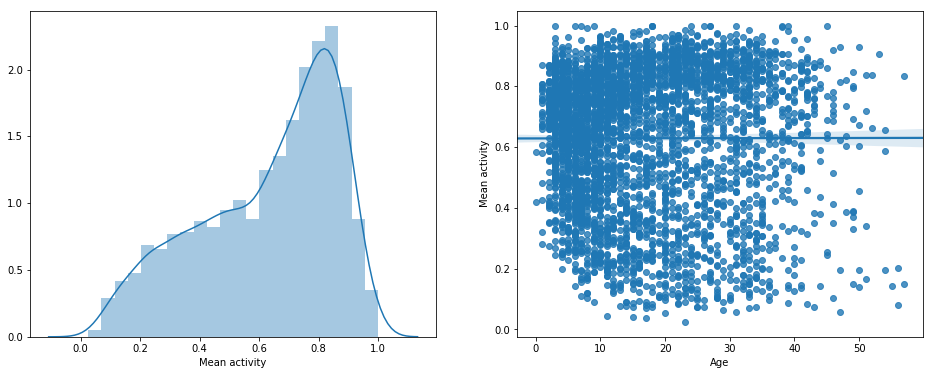

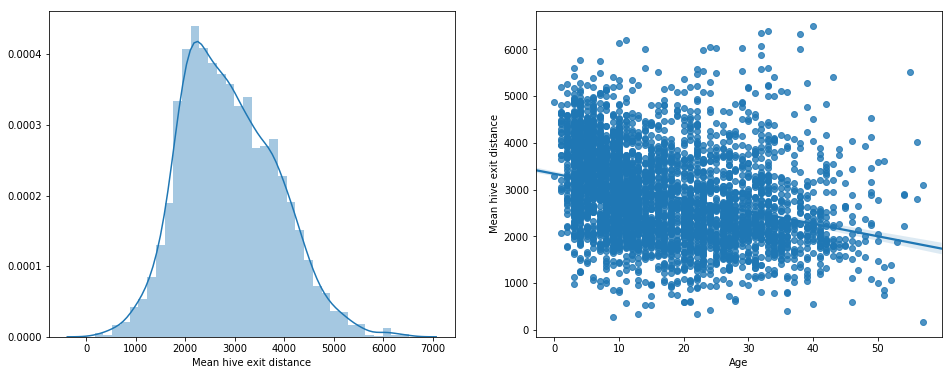

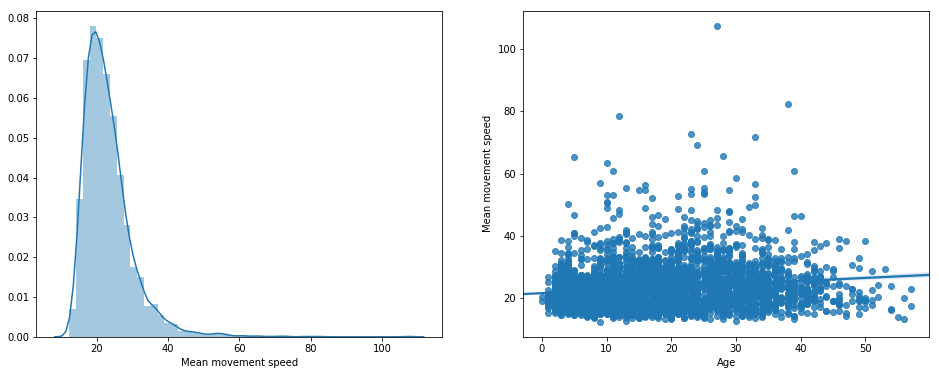

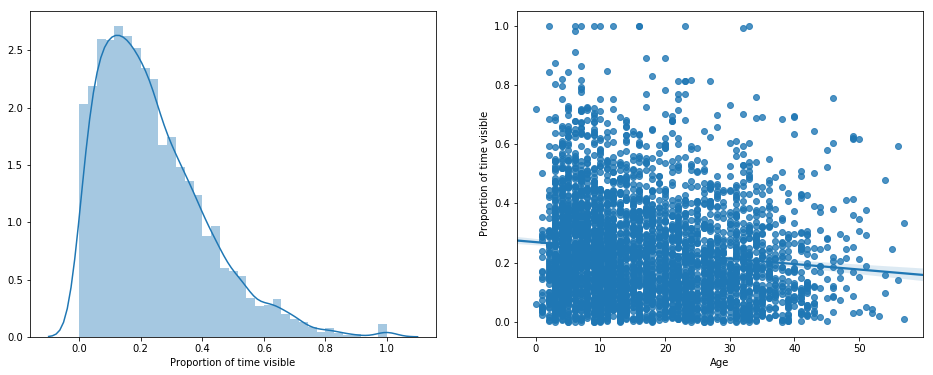

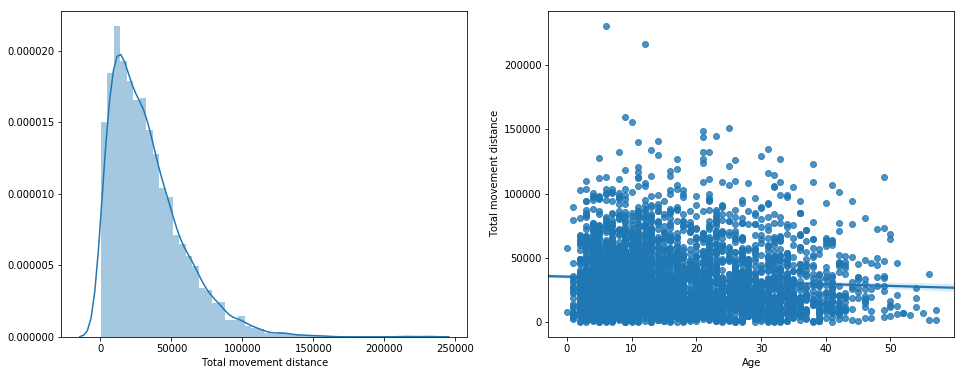

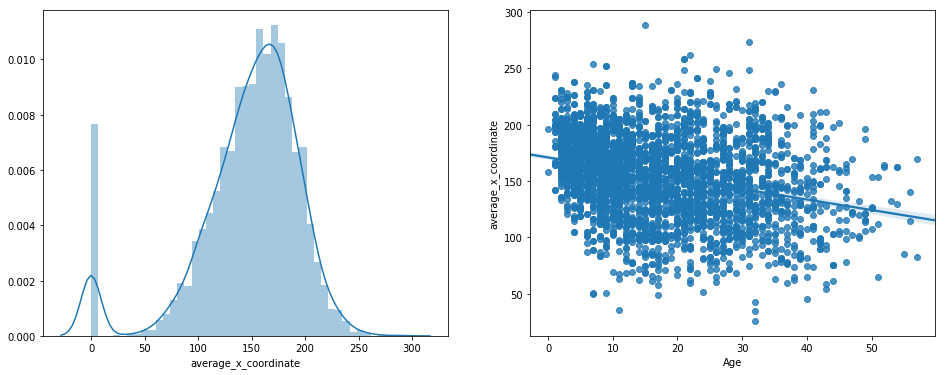

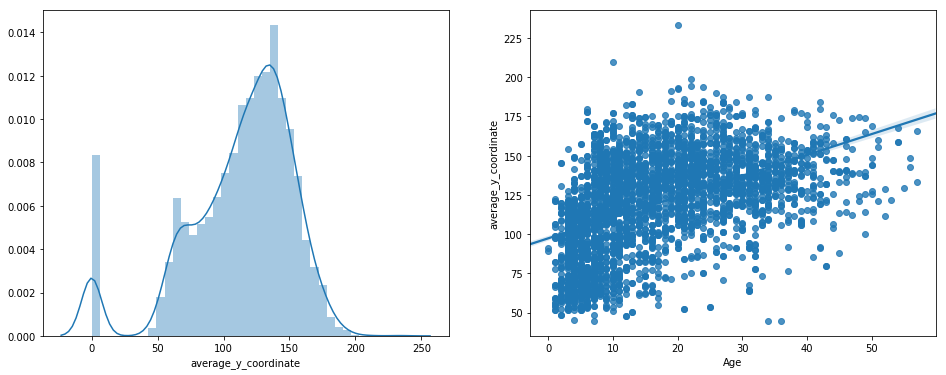

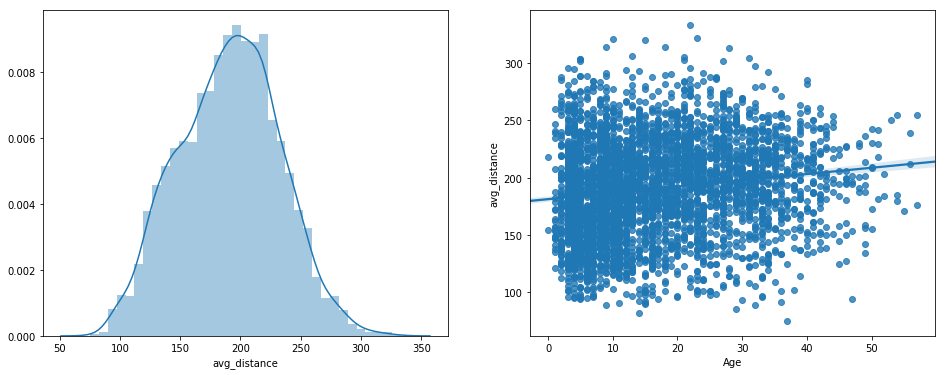

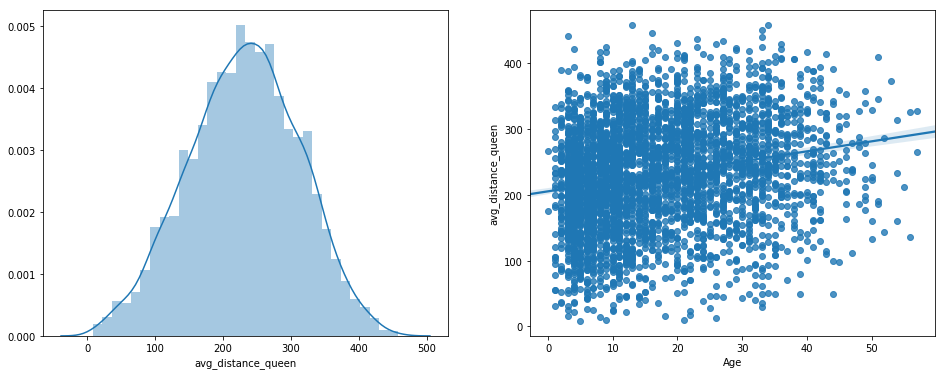

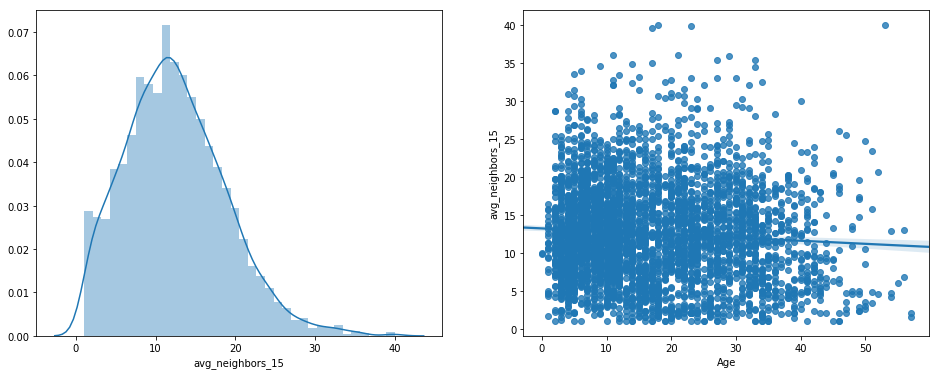

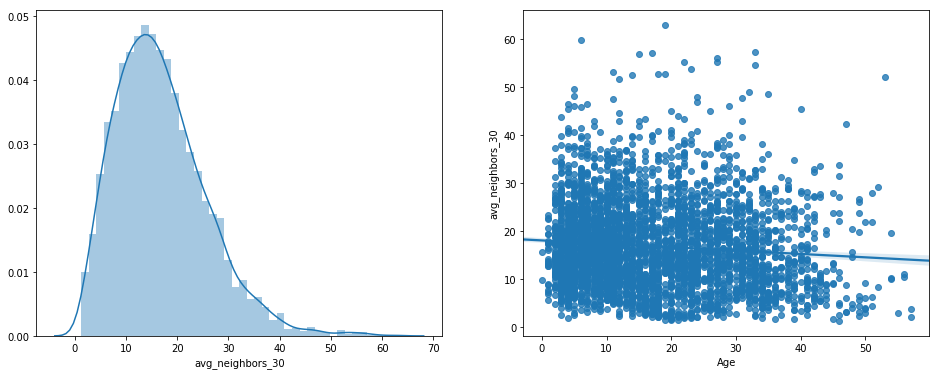

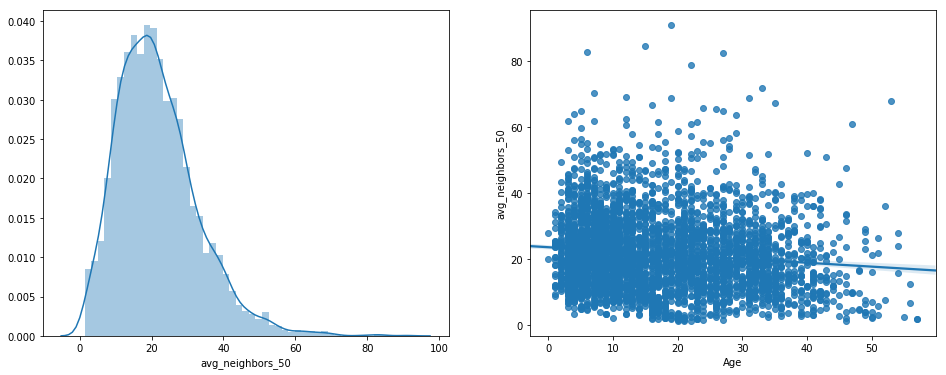

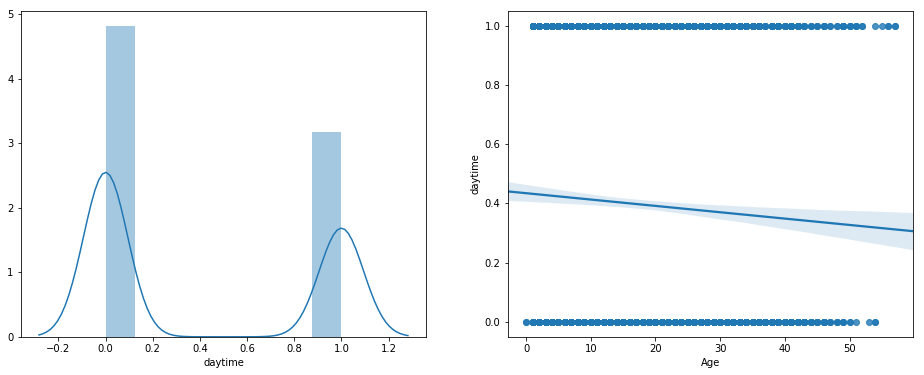

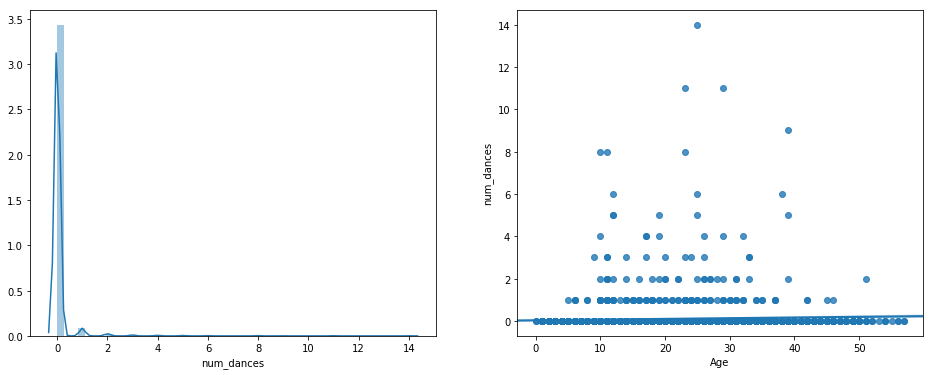

In [135]:
for feature in tfeatures.features.columns:
    if feature in ('bee_id', 'Age', 'day'):
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.distplot(tfeatures.features[feature].fillna(0), ax=axes[0])
    sns.regplot('Age', feature, tfeatures.features, ax=axes[1])

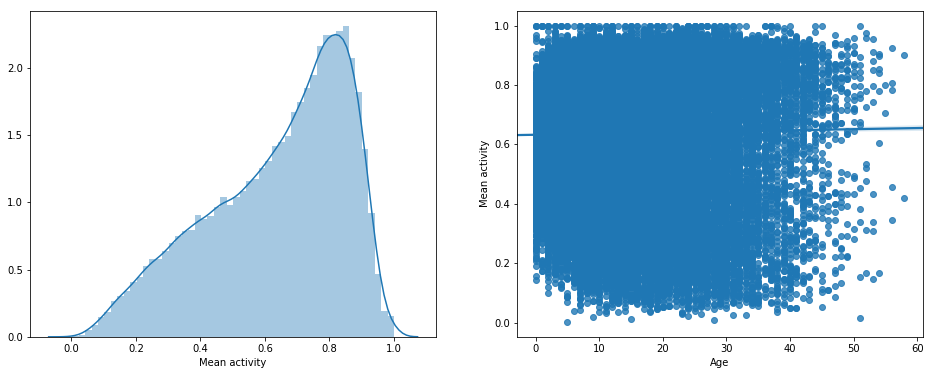

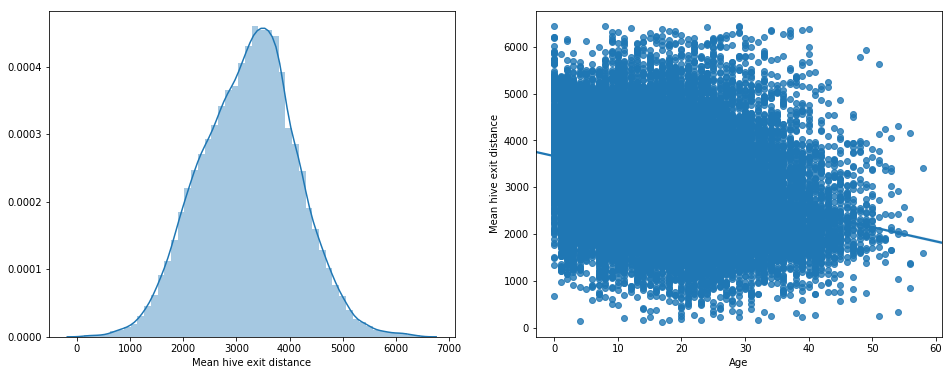

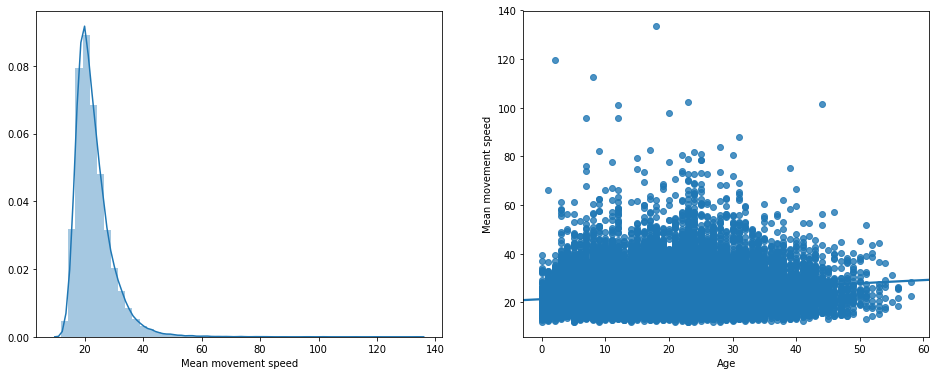

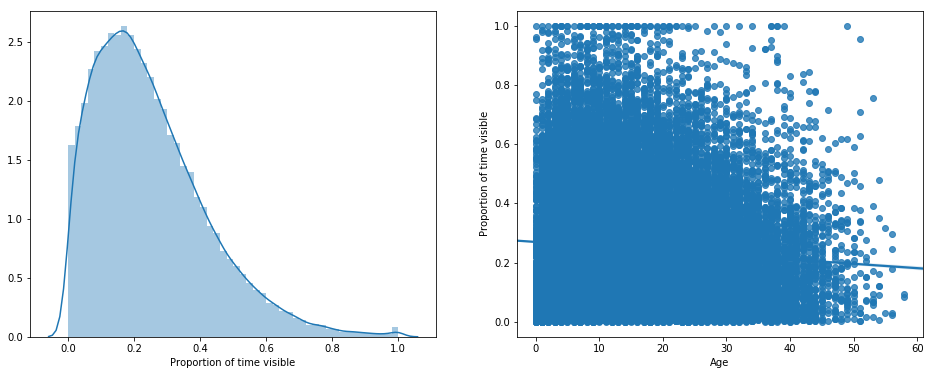

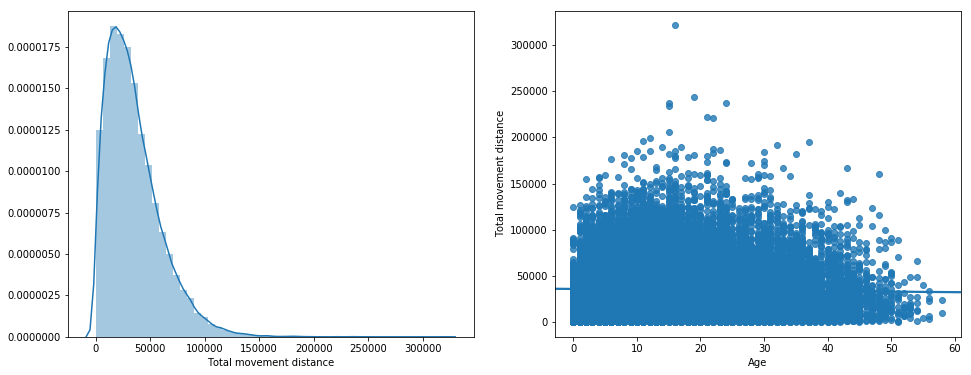

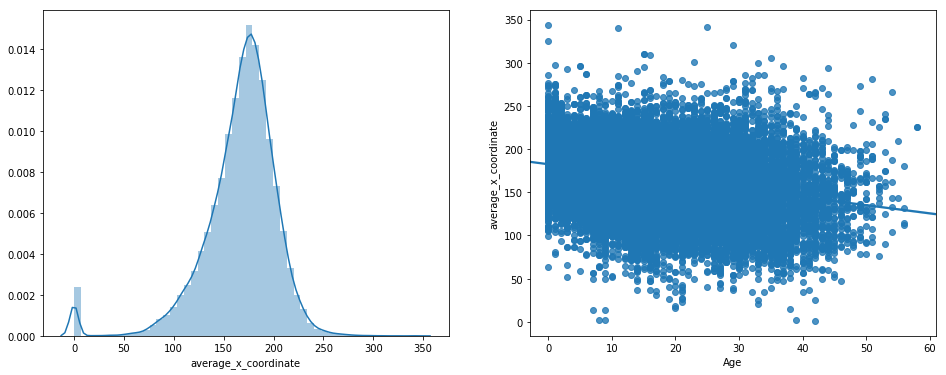

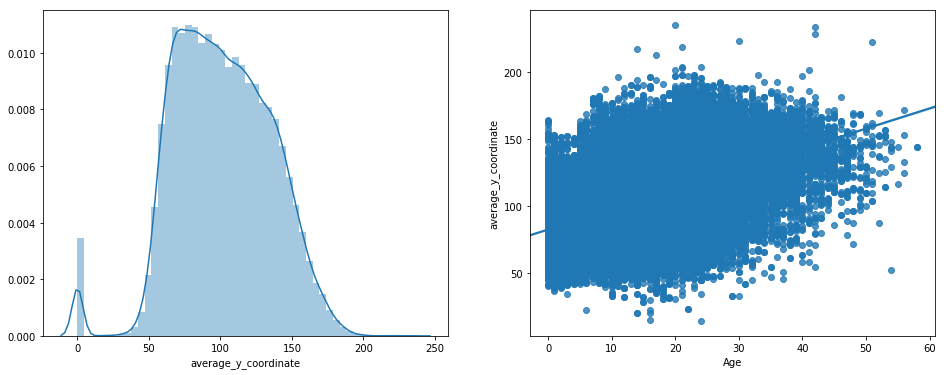

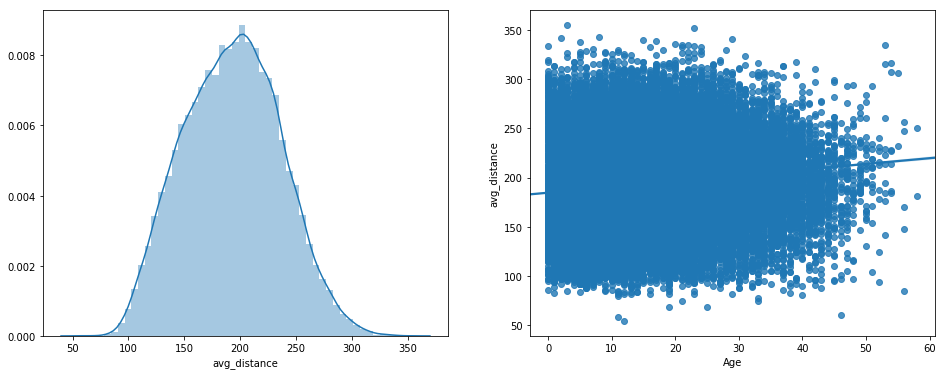

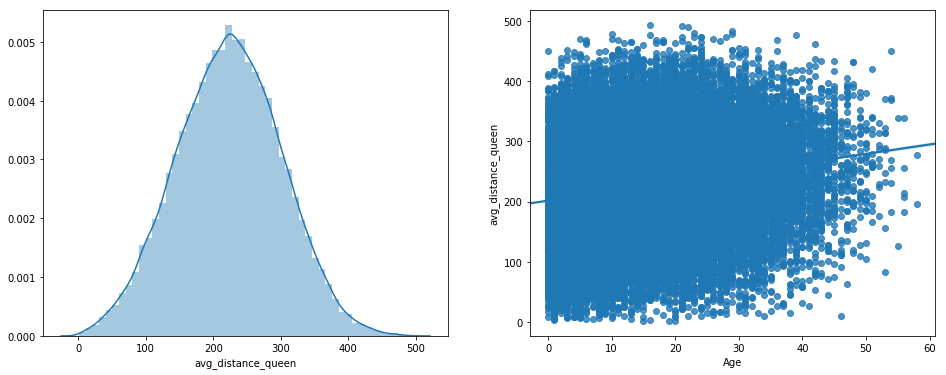

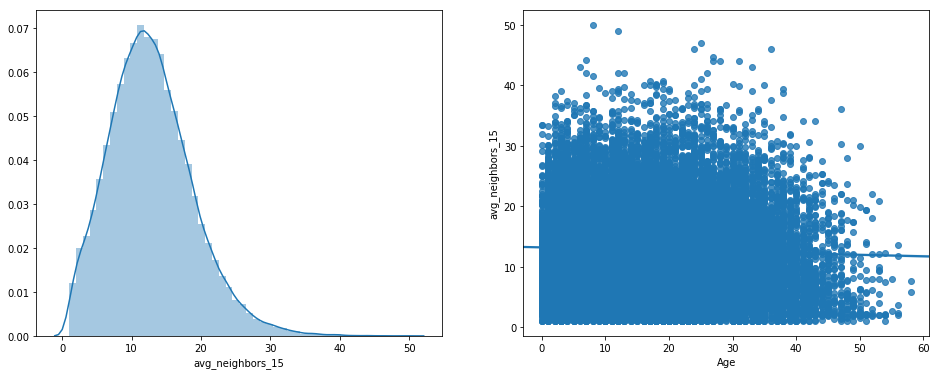

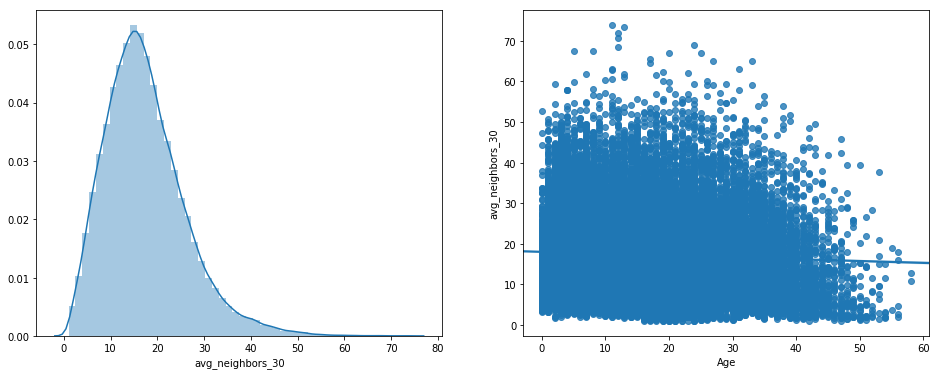

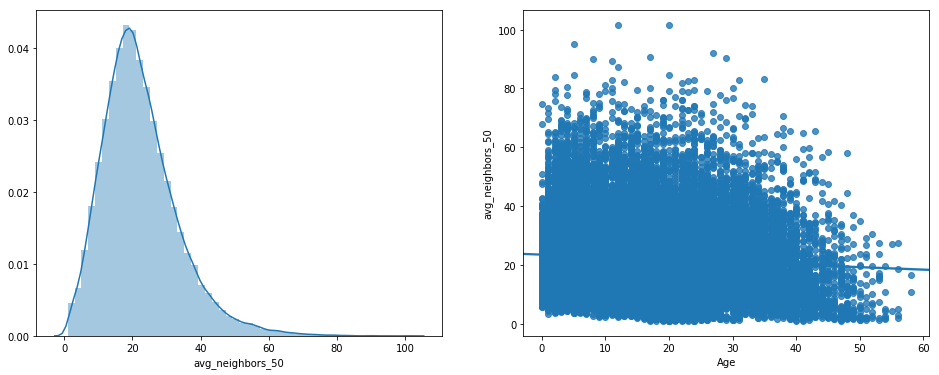

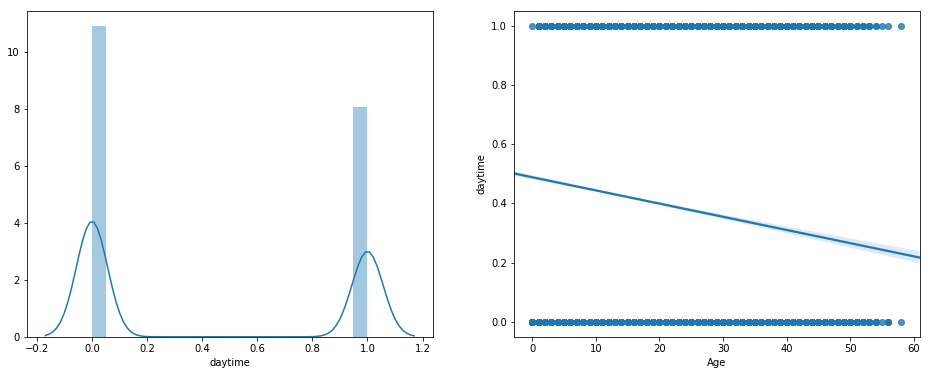

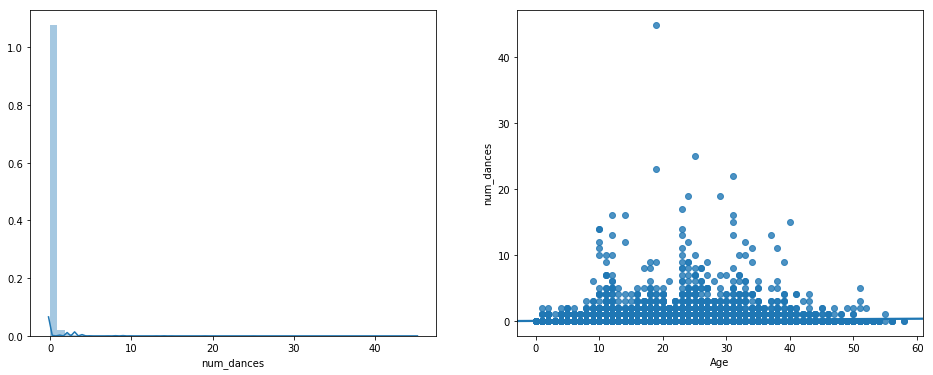

In [136]:
for feature in tfeatures_2.features.columns:
    if feature in ('bee_id', 'Age', 'day'):
        continue

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.distplot(tfeatures_2.features[feature].fillna(0), ax=axes[0])
    sns.regplot('Age', feature, tfeatures_2.features, ax=axes[1])

In [203]:
dead_data_df = tfeatures.features.copy()
dead_data_df['dies'] = 1
dead_data_df = dead_data_df.drop(['bee_id'], axis=1)
alive_data_df = tfeatures_2.features.copy()
alive_data_df['dies'] = 0
alive_data_df = alive_data_df.drop(['bee_id'], axis=1)

In [204]:
dead_data_df = dead_data_df.sample(frac=1).reset_index(drop=True)
alive_data_df = alive_data_df.sample(frac=1).reset_index(drop=True)

#undersampling part
dying_samples = dead_data_df.shape[0]
alive_indices = alive_data_df[alive_data_df.dies == 0].index
random_ratio = random.uniform(2, 4)
random_indices = np.random.choice(alive_indices, dying_samples, replace=False) #int(np.floor(dying_samples*random_ratio))
ratio = np.ceil(alive_data_df.shape[0] / dying_samples)

trainingsdataset = pd.concat([dead_data_df, alive_data_df.loc[random_indices]], ignore_index=True) #.loc[random_indices]
print(trainingsdataset.shape)

(7592, 16)


In [205]:
trainingsdataset = trainingsdataset.sample(frac=1).reset_index(drop=True)
trainingsdataset.head(20)

,Age,Mean activity,Mean hive exit distance,Mean movement speed,Proportion of time visible,Total movement distance,average_x_coordinate,average_y_coordinate,avg_distance,avg_distance_queen,avg_neighbors_15,avg_neighbors_30,avg_neighbors_50,daytime,num_dances,dies
0,19.0,0.936364,2251.541445,50.613486,0.019247,5213.189076,164.842105,146.894737,249.116999,304.261184,15.666667,17.600000,25.333333,0,0.0,0
1,8.0,0.704494,2121.933145,22.980814,0.286318,42514.505033,212.300000,67.700000,211.657986,244.864073,10.382979,15.702857,22.923858,1,0.0,0
2,4.0,0.571188,3254.824178,15.940421,0.244003,27050.894782,161.178571,67.392857,99.194694,214.761188,7.805882,9.912162,17.266458,1,0.0,1
3,3.0,0.786865,2188.893939,24.373586,0.194518,30954.453598,153.469388,83.081633,229.953311,233.602726,10.200000,9.636364,17.000000,0,0.0,1
4,3.0,0.774278,3863.753441,19.125204,0.031776,5641.935318,187.896552,66.689655,150.739102,186.674789,7.875000,5.981308,10.299107,1,0.0,0
5,32.0,0.771504,2474.607418,22.702177,0.139660,26675.058142,115.627907,122.534884,193.307498,232.169005,13.777778,22.924528,26.825000,0,0.0,0
6,17.0,0.548994,3407.534713,17.272464,0.417685,36289.447585,83.703704,129.444444,124.217114,204.547277,9.963608,13.924096,17.927256,1,0.0,1
7,18.0,0.814361,2972.954465,23.342259,0.240602,46591.148691,196.862069,119.689655,187.719477,301.216333,26.610169,35.883117,45.205882,0,0.0,1
8,13.0,0.755142,4166.136932,20.766574,0.361082,64044.114972,114.115385,99.153846,139.343700,246.484736,7.740113,7.089552,9.722034,1,0.0,1
9,7.0,0.415377,3726.830627,18.545444,0.710934,64222.871222,171.717391,63.608696,152.956093,185.058224,9.404255,9.505747,6.520492,1,0.0,1


In [206]:
target = trainingsdataset['dies'].copy()
data = trainingsdataset.drop(['dies'], axis=1)

In [207]:
training_data, test_data, training_target, test_target = train_test_split(data, target, test_size=0.25)
#test_data = pd.concat([test_data, alive_data_df.loc[2296:].drop(['dies'], axis=1)])
#print(test_target.shape)
#test_target = pd.concat([test_target, alive_data_df.loc[2296:]['dies']], ignore_index=True)
#print(test_target.shape)

#sample_weight = np.array([ratio if i == 0 else 1 for i in training_target])
#print(sample_weight)

In [208]:
imp = Imputer(missing_values='NaN', strategy='median', axis=1)
imp = imp.fit(training_data)

training_data_imp = imp.transform(training_data)
test_data = imp.transform(test_data)

dummy = DummyClassifier(strategy='uniform',random_state=0)
dct = DecisionTreeClassifier(max_features=3, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced')
etc = ExtraTreesClassifier(n_estimators=1000, max_features=None, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced_subsample')
rfc = RandomForestClassifier(n_estimators=1000, max_features=None, max_depth=None, min_samples_split=2, random_state=0, class_weight='balanced_subsample')
ada = AdaBoostClassifier(n_estimators=1000, base_estimator=rfc)
#gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
gbc = GradientBoostingClassifier(n_estimators= 1000, max_leaf_nodes= 4, max_depth= None, random_state= 2, min_samples_split= 5)
nc = NearestCentroid()
qda = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False,
                              store_covariances=None, tol=0.0001)

dummy=dummy.fit(training_data_imp, training_target)
dct=dct.fit(training_data_imp, training_target)
etc=etc.fit(training_data_imp, training_target)
rfc=rfc.fit(training_data_imp, training_target)
ada=ada.fit(training_data_imp, training_target)
#gbr=gbr.fit(training_data_imp, training_target)
gbc = gbc.fit(training_data_imp, training_target)
nc = nc.fit(training_data_imp, training_target)
qda = qda.fit(training_data_imp, training_target)

In [209]:
print(dummy.score(test_data, test_target))
print(dct.score(test_data, test_target))
print(etc.score(test_data, test_target))
print(rfc.score(test_data, test_target))
print(ada.score(test_data, test_target))
#print(gbr.score(test_data, test_target))
print(gbc.score(test_data, test_target))

0.5142255005268704
0.5927291886195996
0.672286617492097
0.6628029504741834
0.6622760800842993
0.6622760800842993


In [210]:
print(dummy.predict(test_data).sum())
print(dct.predict(test_data).sum())
print(etc.predict(test_data).sum())
print(rfc.predict(test_data).sum())
print(ada.predict(test_data).sum())
#print(gbr.predict(test_data).sum())
print(gbc.predict(test_data).sum())

963
968
1001
1007
1008
944


In [211]:
scores = cross_val_score(dummy, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, dummy.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, dummy.predict(test_data))))

cross_val_scores:0.5082056846762729
mean_squared_error:0.4857744994731296
f1_score:0.5074786324786325


cross_val_scores:0.554984069835555
mean_squared_error:0.40727081138040044
f1_score:0.5881726158763986


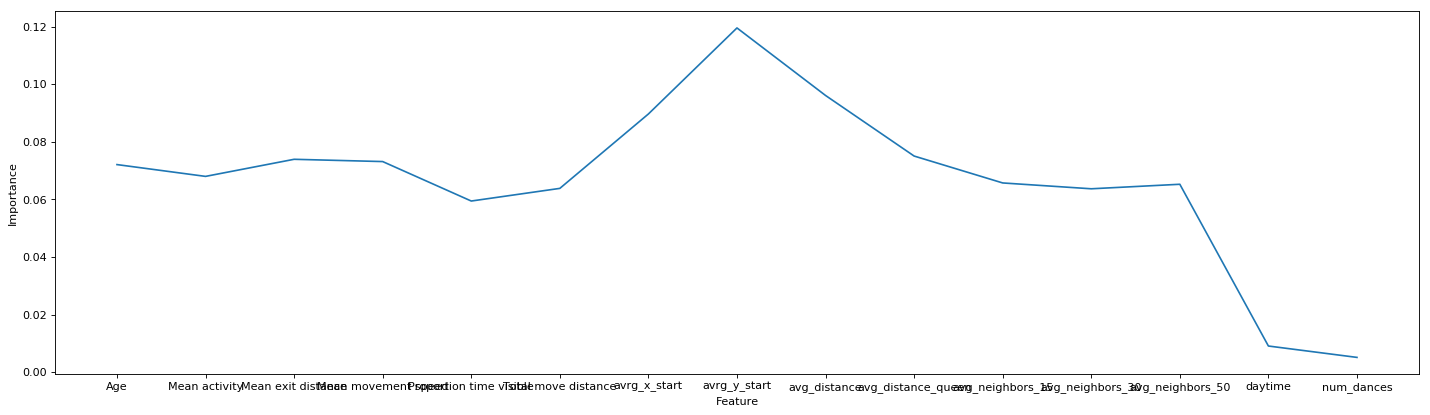

In [212]:
scores = cross_val_score(dct, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, dct.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, dct.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(dct.feature_importances_)
plt.show()

cross_val_scores:0.6216097525319609
mean_squared_error:0.32771338250790305
f1_score:0.6743455497382199


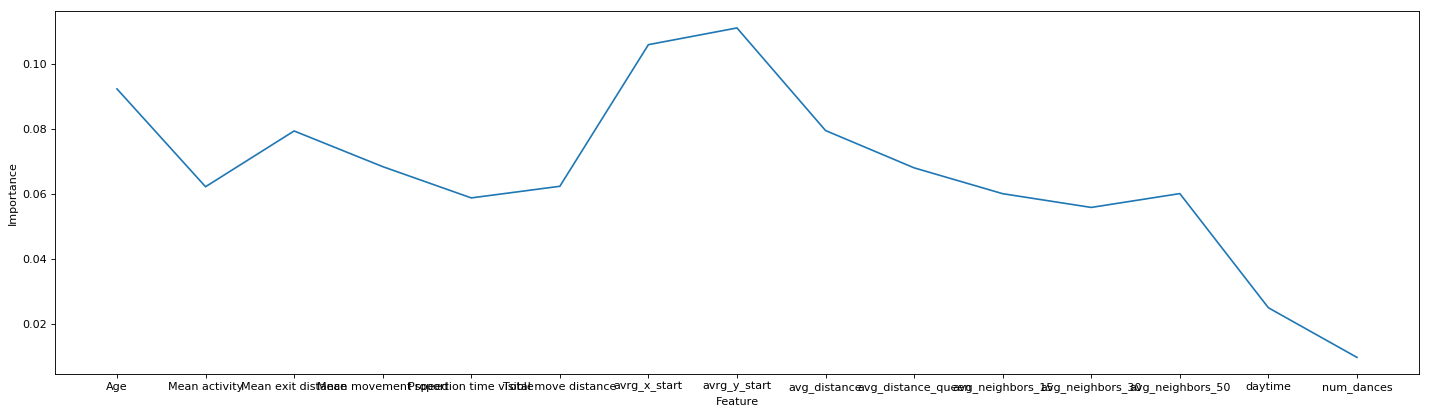

In [213]:
scores = cross_val_score(etc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, etc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, etc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(etc.feature_importances_)
plt.show()

cross_val_scores:0.6291850600910912
mean_squared_error:0.33719704952581664
f1_score:0.6659707724425887


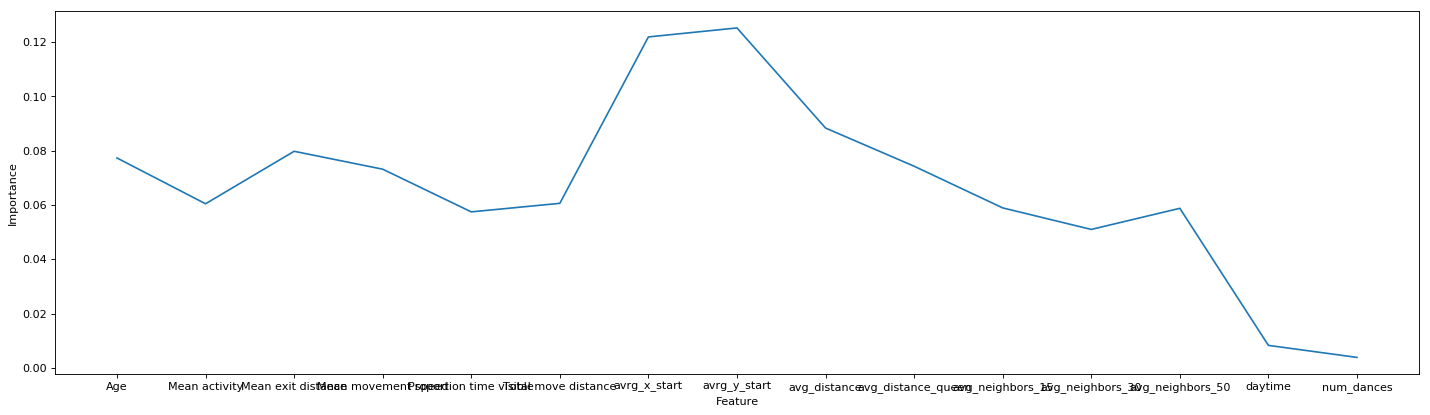

In [214]:
scores = cross_val_score(rfc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, rfc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, rfc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(rfc.feature_importances_)
plt.show()

cross_val_scores:0.6293053447045217
mean_squared_error:0.3377239199157007
f1_score:0.665623369848722


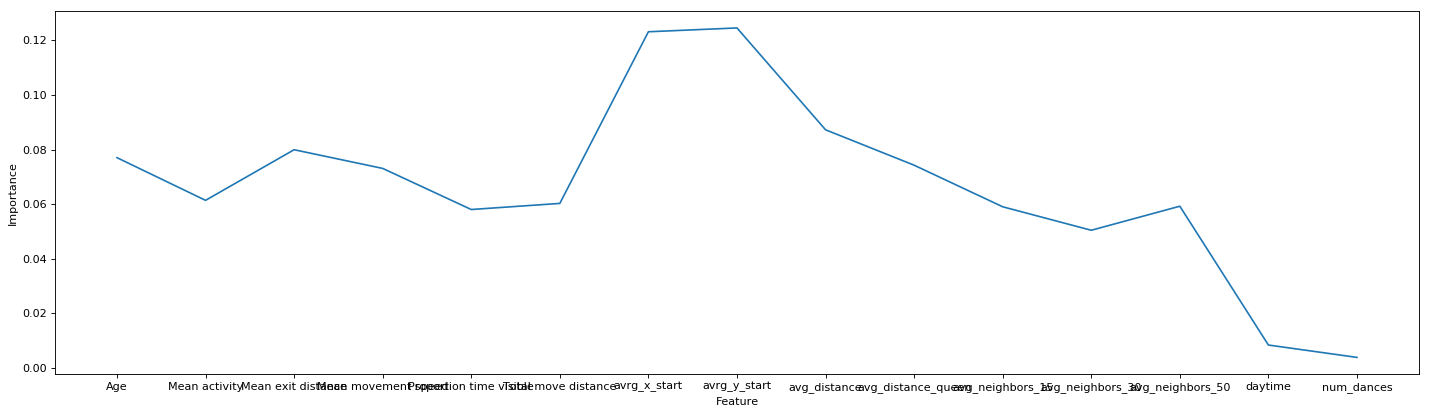

In [215]:
scores = cross_val_score(ada, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, ada.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, ada.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(ada.feature_importances_)
plt.show()

In [216]:
#scores = cross_val_score(gbr, test_data, test_target, scoring='f1')
#print('cross_val_scores:' + str(scores.mean()))
#print('feature_importances:' + str(gbr.feature_importances_))
#print('mean_squared_error:' + str(mean_squared_error(test_target, gbr.predict(test_data))))

#plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.xticks(np.arange(14), ('Age', 'Mean movement speed', 'Mean activity','Total move distance', 'Mean exit distance', 'Proportion time visible', 'avg_distance', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'avg_distance_queen', 'num_dances', 'avrg_x_start', 'avrg_y_start'))
#plt.plot(gbr.feature_importances_)
#plt.show()

In [217]:
scores = cross_val_score(nc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, nc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, nc.predict(test_data))))

cross_val_scores:0.5457327705643017
mean_squared_error:0.48314014752370915
f1_score:0.5449131513647641


In [218]:
scores = cross_val_score(qda, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, qda.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, qda.predict(test_data))))

cross_val_scores:0.572754206711295
mean_squared_error:0.3487881981032666
f1_score:0.5943627450980391


cross_val_scores:0.6014744605183714
mean_squared_error:0.3377239199157007
f1_score:0.6540744738262277


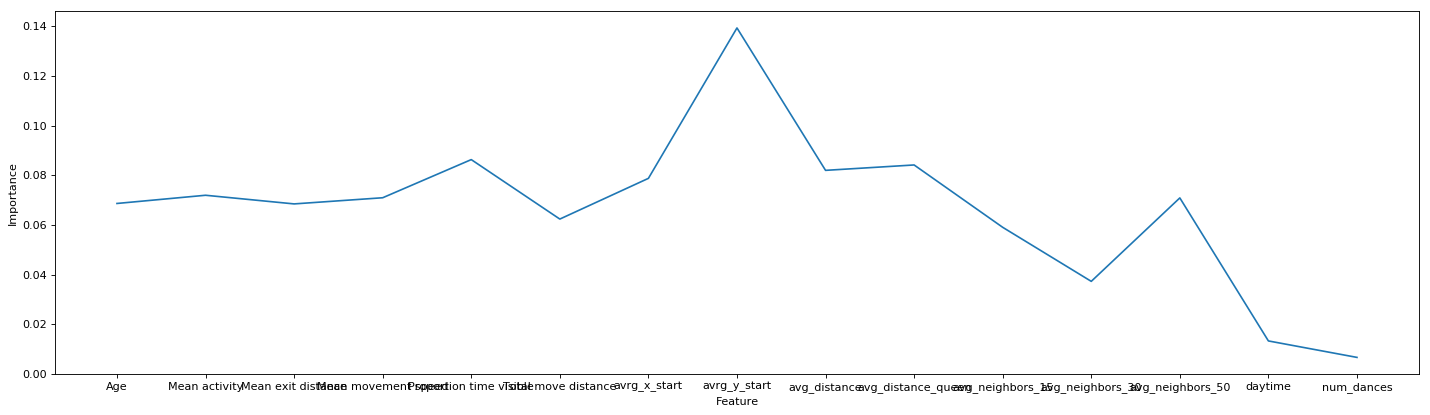

In [219]:
scores = cross_val_score(gbc, test_data, test_target, scoring='f1')
print('cross_val_scores:' + str(scores.mean()))
print('mean_squared_error:' + str(mean_squared_error(test_target, gbc.predict(test_data))))
print('f1_score:' + str(f1_score(test_target, gbc.predict(test_data))))

plt.figure(num=None, figsize=(22, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(np.arange(15), ('Age', 'Mean activity','Mean exit distance','Mean movement speed', 'Proportion time visible','Total move distance',  'avrg_x_start', 'avrg_y_start' , 'avg_distance', 'avg_distance_queen', 'avg_neighbors_15', 'avg_neighbors_30', 'avg_neighbors_50', 'daytime', 'num_dances'))
plt.plot(gbc.feature_importances_)
plt.show()

In [220]:
print(test_target.shape)
print(test_target.sum())

(1898,)
909


In [221]:
print(days_skipped)

[2, 1]
